<a href="https://colab.research.google.com/github/IngyBadawi/Image-Segmentation/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #2 Image Segmentation

Imports

In [10]:
import numpy as np

#For visualization
from matplotlib import image as img
from matplotlib import pyplot as plt
import math
import scipy.io
from PIL import Image
import random

#For file handling
from google.colab import files

#For Unzipping
from zipfile import ZipFile
import glob

#For segmentation
import cv2 as cv
import os

## 1. Download the Dataset and Understand the Format

In [ ]:
!wget -q {"http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"}
!tar -xzf /content/BSR_bsds500.tgz

* Unzip and extract images

In [ ]:
# Creating the output directory
!mkdir '/content/output'
!mkdir '/content/output/Ground-Truth'

#Get the images for training
train = sorted(glob.glob("BSR/BSDS500/data/images/train/**/*.jpg", recursive=True))

#Get the images for testing
test = sorted(glob.glob("BSR/BSDS500/data/images/test/**/*.jpg", recursive=True))
test = test[0:50]

#Get the ground-truth for training
gt_train = sorted(glob.glob("BSR/BSDS500/data/groundTruth/train/**/*.mat", recursive=True))

#Get the ground-truth for testing
gt_test = sorted(glob.glob("BSR/BSDS500/data/groundTruth/test/**/*.mat", recursive=True))

## 2. Visualize the image and the ground truth segmentation

In [ ]:
def visualize_image(index, dataset):
  my_path = '/content/output/Ground-Truth' # Defining the path to save the images later
  my_file = str(dataset).lower() + ' ' + str(index) + ' visualization' # Defining the file name to save the images later
  fig, axarr = plt.subplots(2,3,figsize=(20, 10))
  # Specifying which dataset to use depending on the parameter 'dataset' sent to the function
  if dataset == "TRAIN":
    normal_dataset = train
    gt_dataset = gt_train
  if dataset == "TEST":
    normal_dataset = test
    gt_dataset = gt_test
  images = [] # A list to store the image and its ground truth segmentation to use it in plotting them
  normal_img = img.imread(normal_dataset[index])
  images.append(normal_img)

  # Loading the ground truth images from the corresponding .mat file
  ground_truth_img = scipy.io.loadmat(gt_dataset[index])
  ground_truth_img = np.squeeze(ground_truth_img['groundTruth'])

  #Appending the ground truth segmentations in the list 
  for i in range(5):
    curr_ground_truth = ground_truth_img[i][0][0][1]
    images.append(curr_ground_truth)
  
  # Loop through the list and plot each image
  for i in range(len(images)):
    row = i // 3
    col = i % 3
    if i == 0:
      axarr[row][col].imshow(images[0])
    axarr[i // 3][i % 3].imshow(images[i], cmap='Greys', interpolation='nearest')
  
  # Showing the figure and saving it to the output directory
  fig.suptitle(my_file, fontsize=16)
  plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
  plt.show()
  plt.close()
  return

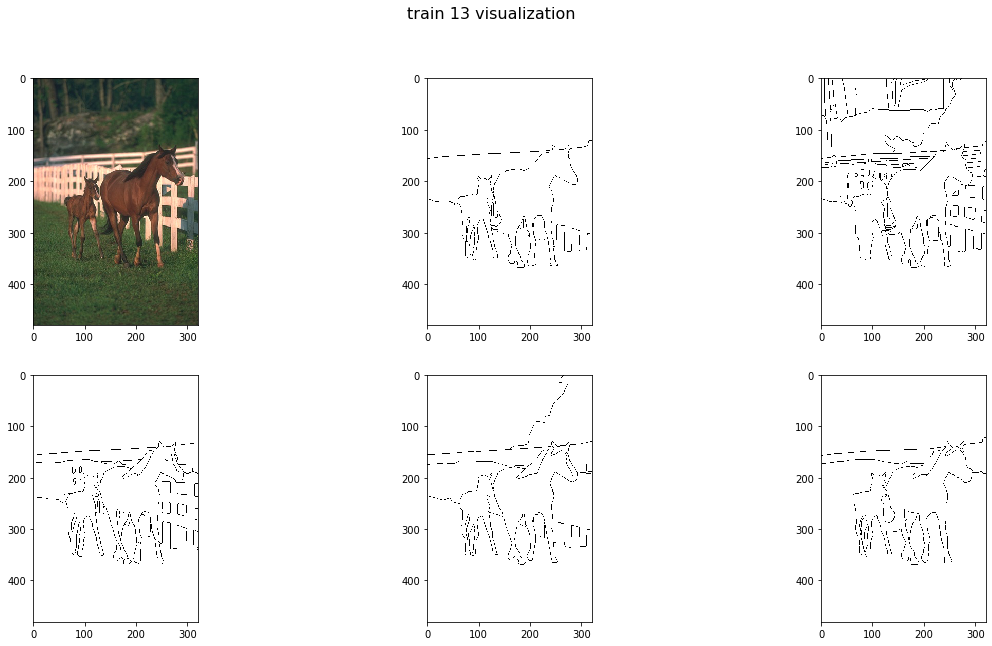

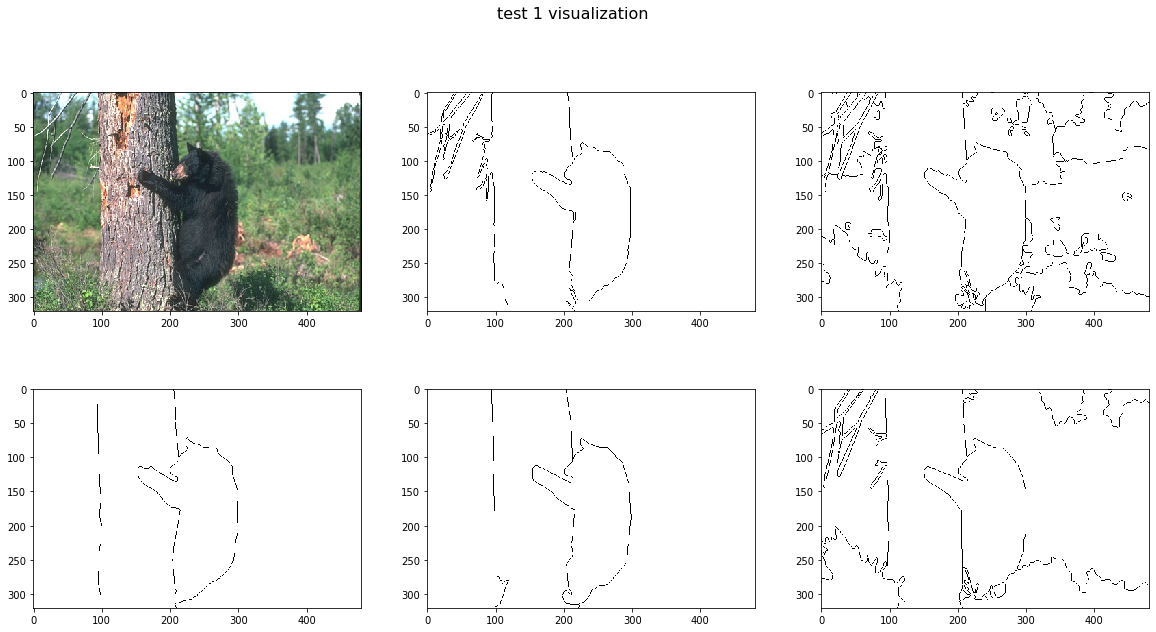

In [ ]:
# A function that returns n random indices in the range between 0 and 45 (since the test dataset is only 50 images)
def get_random_images(n):
  rands = random.sample(range(0, 45), n)
  return rands

datasets = ["TRAIN", "TEST"]
randoms = get_random_images(2) # Calling the above function to get 2 random images to visualize

# Visualize a sample from training dataset and a sample from test data set alternatively
for i in range(len(randoms)):
  visualize_image(randoms[i], datasets[i & 1])

In [ ]:
# Zipping and downloading output folder as output.zip
!zip -qq -r /content/output.zip /content/output
files.download("/content/output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Segmentation Using K-means

In [8]:
def image_segmentaion(array, K, path):

    #Array to store images
    result=np.zeros([],int)

    #Array to store labels
    img = cv.imread(array[0])
    Z = img.reshape((-1,3))
    labels=np.zeros((len(array),Z.shape[0]))

    #Get Current Directory to save images
    path = os.path.join(path , str(K))
    if(not os.path.exists(path)):
        os.mkdir(path)

    #Segmenting all 200 train images
    for i in range(len(array)):
        
        img = cv.imread(array[i])
        Z = img.reshape((-1,3))
        
        # convert to np.float32
        Z = np.float32(Z)
        
        # define criteria, number of clusters(K) and apply kmeans()
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret, label, center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
        
        #Store labels
        labels[i]=label.reshape(1,label.shape[0])

        # Now convert back into uint8, and make original image
        center = np.uint8(center)
        res = center[label.flatten()]
        seg_img = res.reshape((img.shape))

        #Save them to an array
        #result=np.append(result,res2)

        #Save segmented images 
        #if len(os.listdir('path')) != 0: (If segmentations changed for same K, then they have to be replaced)
        new_name=os.path.basename(array[i])
        new_name= 'seg_'+ new_name
        cv.imwrite(os.path.join(path ,new_name), seg_img)

    return labels

In [11]:
## Create a directory to save all segmented images inside
# Directory
directory = "Colored_Images"
    
# Parent Directory path
parent_dir = "."
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Image Segmentation
K=[3,5,7,9,11]

labels=[np.array([]) for i in K] #Array of all labels
j=0
for i in K:
    labels[j] = image_segmentaion(train, i, path)
    j+=1

KeyboardInterrupt: ignored

## 4. Big Picture

## 5. Extra